In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from tqdm import tqdm
from time import time

# TODO: Move functions to separate modules
import functions as f

import core.background_model as background_model
import core.clique_finding as cf
import core.stats 

# GLOBALS

TTN_BIN = 4275
BIN_MAP_PATH = 'mappings/bin_map_human_100000.bed'
GTF_PATH = 'mappings/gencode.v38.annotation.gtf'
GENE_BIN_PATH = 'mappings/gene_bins.txt'
NON_GENE_BIN_PATH = 'mappings/non_gene_bins.txt'


gene_bins = []
with open('mappings/gene_bins.txt', 'r') as file:
    for line in file:
        gene_bins.append(line.strip())
gene_bins = [int(x) for x in gene_bins]


non_gene_bins = []
with open('mappings/non_gene_bins.txt', 'r') as file:
    for line in file:
        non_gene_bins.append(line.strip())
non_gene_bins = [int(x) for x in non_gene_bins]



def build_walk_index(contact_matrix):
    """
    Precompute for each node:
      - neighbors[i]: 1D int array of neighbors
      - cdfs[i]:      1D float array of cumulative probabilities
    """
    N = contact_matrix.shape[0]
    neighbors = [None]*N
    cdfs      = [None]*N

    for i in tqdm(range(N)):
        w = contact_matrix[i]
        idx = np.nonzero(w)[0]
        if idx.size == 0:
            neighbors[i] = np.empty(0, dtype=int)
            cdfs[i]      = np.empty(0, dtype=float)
        else:
            probs = w[idx] / w[idx].sum()
            neighbors[i] = idx
            cdfs[i]      = np.cumsum(probs)
    return neighbors, cdfs






# LOAD CONTACT MATRICES
# contact_matrix_zero = np.load('data/hic/wildtype_100kb_zeroed.npy')
contact_matrix_zero = np.load('data/hic/wt_100kb_balanced_zeroed.npy')


In [ ]:
def plot_pval_heatmap(csv_path):
    # Load and preprocess data
    df = pd.read_csv(csv_path)
    df.set_index('alpha', inplace=True)

    # Find min p-value and its coordinates
    min_val = df.min().min()
    min_alpha, min_size = None, None
    for alpha in df.index:
        for size in df.columns:
            if df.loc[alpha, size] == min_val:
                min_alpha = alpha
                min_size = int(size)
                break

    # Plot
    plt.figure(figsize=(12, 6))
    plt.imshow(df.values, cmap="viridis", aspect='auto')
    plt.colorbar(label="p-value")
    plt.xticks(ticks=np.arange(len(df.columns)), labels=df.columns)
    plt.yticks(ticks=np.arange(len(df.index)), labels=df.index)
    plt.xlabel("Clique Size")
    plt.ylabel("Alpha")
    plt.title("P-values by Clique Size and Alpha")

    # Highlight minimum
    plt.scatter(df.columns.get_loc(str(min_size)), df.index.get_loc(min_alpha),
                color='red', label=f"Min p-value\nα={min_alpha}, size={min_size}\np={min_val:.4g}")
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_significant_contour(csv_path, threshold=0.05):
    # Load and preprocess data
    df = pd.read_csv(csv_path)
    df.set_index('alpha', inplace=True)
    df = df.astype(float)

    # Find min p-value and its coordinates
    min_val = df.min().min()
    min_alpha, min_size = None, None
    for alpha in df.index:
        for size in df.columns:
            if df.loc[alpha, size] == min_val:
                min_alpha = float(alpha)
                min_size = float(size)
                break

    # Prepare grid for contour
    X, Y = np.meshgrid(df.columns.astype(float), df.index.astype(float))
    Z = df.values

    # Mask non-significant values
    Z_masked = np.ma.masked_where(Z > threshold, Z)

    # Plot
    plt.figure(figsize=(12, 6))
    contour = plt.contourf(X, Y, -np.log10(Z_masked), levels=20, cmap='viridis')
    plt.colorbar(label='-log10(p-value)')

    # Add contour line at threshold
    plt.contour(X, Y, Z, levels=[threshold], colors='red', linestyles='dashed')

    # Highlight minimum
    plt.scatter(min_size, min_alpha, color='white', edgecolors='black', zorder=10,
                label=f"Min p-value\nα={min_alpha}, size={int(min_size)}\np={min_val:.2e}")

    plt.xlabel("Clique Size")
    plt.ylabel("Alpha")
    plt.title("Significant P-values (p < 0.05) by Clique Size and Alpha")
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

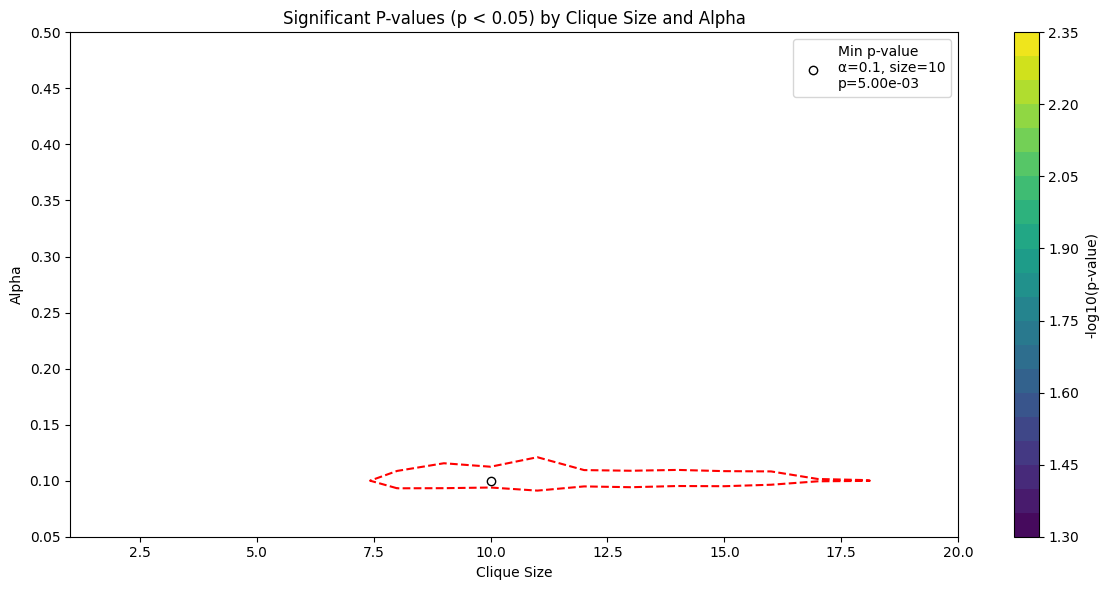

In [16]:
plot_significant_contour('pvalue_matrix.csv', threshold=0.05)

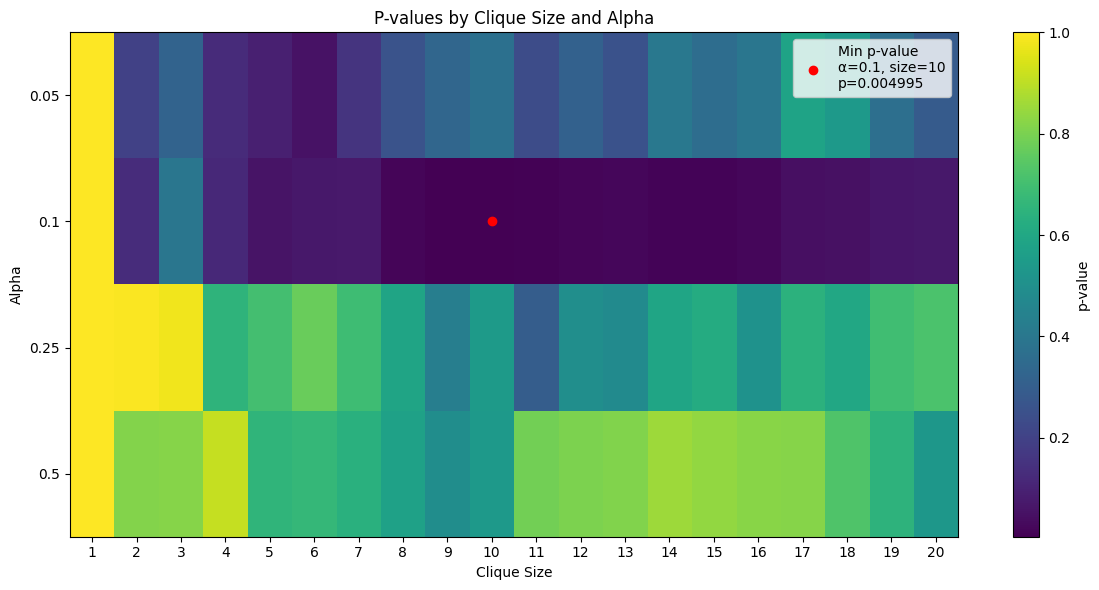

In [11]:
plot_pval_heatmap('pvalue_matrix.csv')

In [4]:
neighbors, cdfs = build_walk_index(contact_matrix_zero) 

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30894/30894 [00:10<00:00, 2910.32it/s]


In [ ]:
def optimize_clique_size(
    contact_matrix,
    max_clique_size,
    seed_bin,
    num_samples=1000,
    clique_alg=cf.find_greedy_clique,
    **alg_kwargs
):
    """
    Runs a single full-size clique search with `clique_alg`, then trims down to all sizes.

    Parameters:
    - contact_matrix: Hi-C contact matrix
    - max_clique_size: maximum clique size to search
    - seed_bin: start bin for your TTN clique
    - num_samples: number of random background samples
    - clique_alg: function(contact_matrix, size, seed_bin, **alg_kwargs)
    - alg_kwargs: extra keyword arguments for `clique_alg` (e.g. num_neighbors)

    Returns:
    sizes, ttn_scores, p_values, fold_changes, bg_dists
    """
    print(f"Starting optimize_clique_size: max_clique_size={max_clique_size}, "
          f"seed_bin={seed_bin}, num_samples={num_samples}, alg={clique_alg.__name__}")

    # 1) Full-size TTN clique
    ttn_full = clique_alg(
        contact_matrix,
        max_clique_size,
        seed_bin,
        **alg_kwargs
    )
    print(f"Computed TTN full clique of size {len(ttn_full)} using {clique_alg.__name__}")

    # 2) Background samples (full size)
    bg_full = []
    for _ in tqdm(range(num_samples), desc="Sampling background cliques"):
        rand_bin = np.random.randint(contact_matrix.shape[0])
        bg = clique_alg(
            contact_matrix,
            max_clique_size,
            rand_bin,
            **alg_kwargs
        )
        bg_full.append(bg)
    print("Background sampling complete.")

    sizes = list(range(1, max_clique_size + 1))
    ttn_scores, p_values, fold_changes = [], [], []
    bg_dists = {}

    # 3) Trim & score for each size
    for size in tqdm(sizes, desc="Processing sizes"):

        # TTN subclique
        ttn_sub = ttn_full[:size]
        ttn_score = core.stats.calculate_avg_interaction_strength(
            contact_matrix,
            ttn_sub
        )
 

        # Background scores
        bg_scores = []
        for clique in bg_full:
            sub = clique[:size]
            score = core.stats.calculate_avg_interaction_strength(
                contact_matrix,
                sub
            )
            bg_scores.append(score)
        bg_dists[size] = bg_scores

        # Stats
        median_bg = np.median(bg_scores)
        pval = (np.sum(np.array(bg_scores) >= ttn_score) + 1) / (num_samples + 1)
        fold = ttn_score / median_bg if median_bg != 0 else float('nan')

        # print(f"  Median background: {median_bg:.4f}")
        # print(f"  p-value: {pval:.4f}")
        # print(f"  Fold change: {fold:.4f}")

        ttn_scores.append(ttn_score)
        p_values.append(pval)
        fold_changes.append(fold)

    print("Completed optimize_clique_size")
    return sizes, ttn_scores, p_values, fold_changes, bg_dists



## RW TUNING

In [12]:
sizes, ttn_scores, pvals, folds, bg = optimize_clique_size(
    contact_matrix_zero,
    max_clique_size=20,
    seed_bin=4275,
    num_samples=1000,
    clique_alg=cf.random_walk,
    neighbors=neighbors,
    cdfs=cdfs,
    num_molecules=10000,
    alpha=0.05,  
)

Starting optimize_clique_size: max_clique_size=20, seed_bin=4275, num_samples=1000, alg=random_walk
Computed TTN full clique of size 4275 using random_walk


Sampling background cliques: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [17:04<00:00,  1.02s/it]


Background sampling complete.


Processing sizes:  45%|██████████████████████████████████████████████████████████████████▏                                                                                | 9/20 [00:00<00:00, 79.62it/s]


Size 1/20
  TTN score: 0.0000

Size 2/20
  TTN score: 0.0001

Size 3/20
  TTN score: 0.0000

Size 4/20
  TTN score: 0.0001

Size 5/20
  TTN score: 0.0001

Size 6/20
  TTN score: 0.0001

Size 7/20
  TTN score: 0.0001

Size 8/20
  TTN score: 0.0001

Size 9/20
  TTN score: 0.0001

Size 10/20
  TTN score: 0.0001

Size 11/20
  TTN score: 0.0001

Size 12/20
  TTN score: 0.0001

Size 13/20
  TTN score: 0.0001

Size 14/20
  TTN score: 0.0001

Size 15/20
  TTN score: 0.0001

Size 16/20
  TTN score: 0.0001


Processing sizes:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 17/20 [00:00<00:00, 30.13it/s]


Size 17/20
  TTN score: 0.0001

Size 18/20
  TTN score: 0.0001

Size 19/20
  TTN score: 0.0001


Processing sizes: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 25.03it/s]


Size 20/20
  TTN score: 0.0001
Completed optimize_clique_size


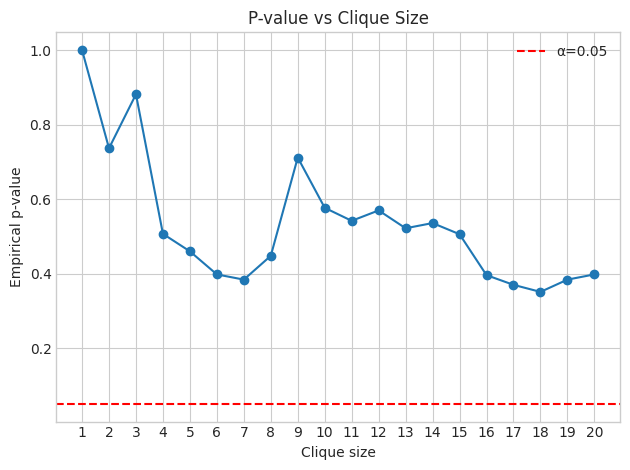

Optimal clique size = 18, p-value = 0.3506


In [13]:
import numpy as np
import matplotlib.pyplot as plt


plt.style.use('seaborn-v0_8-whitegrid')  # Clean modern look
# 1) Plot p-value vs size
plt.figure()
plt.plot(sizes, pvals, marker='o', linestyle='-')
plt.axhline(0.05, color='red', linestyle='--', label='α=0.05')
plt.xlabel('Clique size')
plt.ylabel('Empirical p-value')
plt.title('P-value vs Clique Size')
plt.xticks(sizes)
plt.legend()
plt.tight_layout()
plt.show()

# 2) Choose the size with minimum p-value
opt_idx = int(np.argmin(pvals))
opt_size = sizes[opt_idx]
opt_pval = pvals[opt_idx]
print(f'Optimal clique size = {opt_size}, p-value = {opt_pval:.4f}')

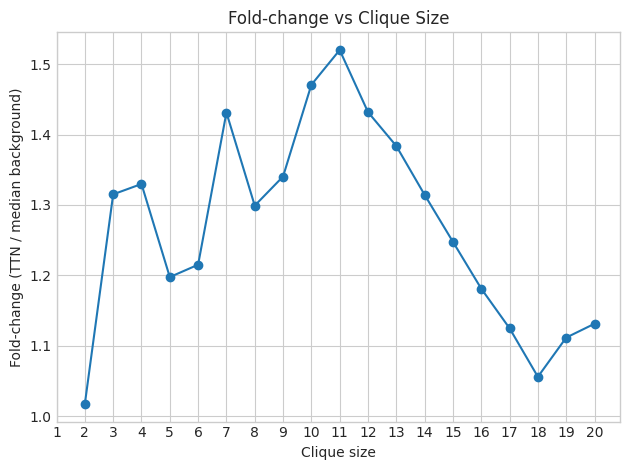

In [10]:
plt.figure()
plt.plot(sizes, folds, marker='o', linestyle='-')
plt.xlabel('Clique size')
plt.ylabel('Fold-change (TTN / median background)')
plt.title('Fold-change vs Clique Size')
plt.xticks(sizes)
plt.tight_layout()
plt.show()

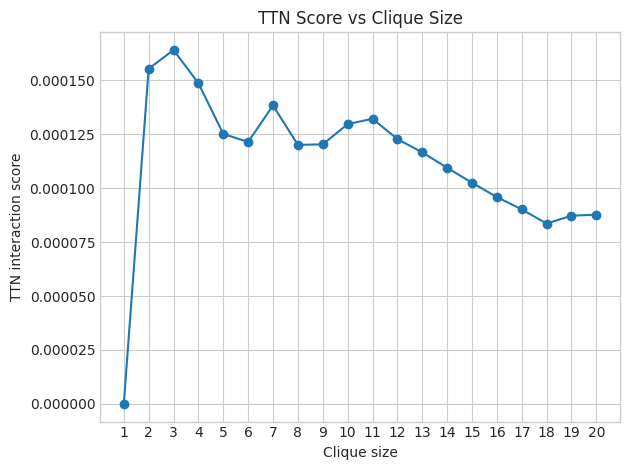

In [11]:
plt.figure()
plt.plot(sizes, ttn_scores, marker='o', linestyle='-')
plt.xlabel('Clique size')
plt.ylabel('TTN interaction score')
plt.title('TTN Score vs Clique Size')
plt.xticks(sizes)
plt.tight_layout()
plt.show()

## Gridsearch RW

In [ ]:

import itertools


def _run_combo(contact_matrix, seed_bin,
               max_clique_size, alpha, num_samples,
               clique_alg, alg_kwargs):
    print(f"Running combo: alpha={alpha}, max_clique_size={max_clique_size}")
    sizes, _, pvals, folds, _ = optimize_clique_size(
        contact_matrix,
        max_clique_size=max_clique_size,
        seed_bin=seed_bin,
        num_samples=num_samples,
        clique_alg=clique_alg,
        **{**alg_kwargs, 'alpha': alpha}
    )
    result = {
        'alpha': alpha,
        'size': max_clique_size,
        'pval': pvals[-1],
        'fold': folds[-1]
    }
    print(f"Completed combo: alpha={alpha}, k={max_clique_size} -> p={result['pval']}, fold={result['fold']}")
    return result


def sweep_parameters(contact_matrix,
                     seed_bin,
                     alphas,
                     clique_sizes,
                     num_samples=500,
                     clique_alg=cf.random_walk,
                     **alg_kwargs):
    combos = list(itertools.product(alphas, clique_sizes))
    total = len(combos)
    print(f"Starting parameter sweep over {total} combos")

    records = []
    for a, k in combos:
        result = _run_combo(
            contact_matrix,
            seed_bin,
            max_clique_size=k,
            alpha=a,
            num_samples=num_samples,
            clique_alg=clique_alg,
            alg_kwargs=alg_kwargs
        )
        records.append(result)

    print("Parameter sweep complete.")
    return pd.DataFrame(records)

# --- Example usage: ---
alphas      = [0.05, 0.1, 0.25, 0.5]
clique_sizes = [5, 10, 15, 20]
df = sweep_parameters(
    contact_matrix=contact_matrix_zero,
    seed_bin=TTN_BIN,
    alphas=alphas,
    clique_sizes=clique_sizes,
    num_samples=500,
    clique_alg=cf.random_walk,
    neighbors=neighbors,
    cdfs=cdfs,
    num_molecules=5000
)

# --- Plotting heatmaps ---
pval_mat = df.pivot(index='alpha', columns='size', values='pval')
fold_mat = df.pivot(index='alpha', columns='size', values='fold')

# 1) p-value heatmap (log scale)
plt.figure(figsize=(6,4))
plt.title('Empirical p-value (log scale)')
plt.imshow(np.log10(pval_mat), aspect='auto', origin='lower',
           extent=[min(clique_sizes)-0.5, max(clique_sizes)+0.5,
                   min(alphas), max(alphas)])
plt.colorbar(label='log10(p-value)')
plt.xlabel('Clique size (k)')
plt.ylabel('Restart prob (α)')
plt.xticks(clique_sizes)
plt.yticks(alphas)
plt.tight_layout()
plt.show()

# 2) Fold-change heatmap
plt.figure(figsize=(6,4))
plt.title('Fold-change (TTN / median bg)')
plt.imshow(fold_mat, aspect='auto', origin='lower',
           extent=[min(clique_sizes)-0.5, max(clique_sizes)+0.5,
                   min(alphas), max(alphas)])
plt.colorbar(label='fold-change')
plt.xlabel('Clique size (k)')
plt.ylabel('Restart prob (α)')
plt.xticks(clique_sizes)
plt.yticks(alphas)
plt.tight_layout()
plt.show()

# 3) Best combo by p-value
best = df.loc[df['pval'].idxmin()]
print(f"Best (α,k) by p-value → α={best.alpha}, k={best.size}, p={best.pval}")

# 4) Best combo by fold-change
best2 = df.loc[df['fold'].idxmax()]
print(f"Best (α,k) by fold-change → α={best2.alpha}, k={best2.size}, fold={best2.fold}")

## hilh

🔄 Starting full sweep over alphas and sizes...
→ Running optimize_clique_size for α=0.05
Starting optimize_clique_size: max_clique_size=20, seed_bin=4275, num_samples=1000, alg=random_walk
Computed TTN full clique of size 4275 using random_walk


Sampling background cliques: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [15:30<00:00,  1.08it/s]


Background sampling complete.


Processing sizes: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 29.07it/s]


Completed optimize_clique_size
   • Completed α=0.05 (collected sizes 1–20)
→ Running optimize_clique_size for α=0.1
Starting optimize_clique_size: max_clique_size=20, seed_bin=4275, num_samples=1000, alg=random_walk
Computed TTN full clique of size 4275 using random_walk


Sampling background cliques: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [07:37<00:00,  2.19it/s]


Background sampling complete.


Processing sizes: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 29.42it/s]


Completed optimize_clique_size
   • Completed α=0.1 (collected sizes 1–20)
→ Running optimize_clique_size for α=0.25
Starting optimize_clique_size: max_clique_size=20, seed_bin=4275, num_samples=1000, alg=random_walk
Computed TTN full clique of size 4275 using random_walk


Sampling background cliques: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:21<00:00,  7.05it/s]


Background sampling complete.


Processing sizes: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 30.05it/s]


Completed optimize_clique_size
   • Completed α=0.25 (collected sizes 1–20)
→ Running optimize_clique_size for α=0.5
Starting optimize_clique_size: max_clique_size=20, seed_bin=4275, num_samples=1000, alg=random_walk
Computed TTN full clique of size 4275 using random_walk


Sampling background cliques: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:48<00:00, 20.54it/s]


Background sampling complete.


Processing sizes: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 30.37it/s]


Completed optimize_clique_size
   • Completed α=0.5 (collected sizes 1–20)
✅ DataFrame assembled: 80 rows
📊 Plotting heatmaps...


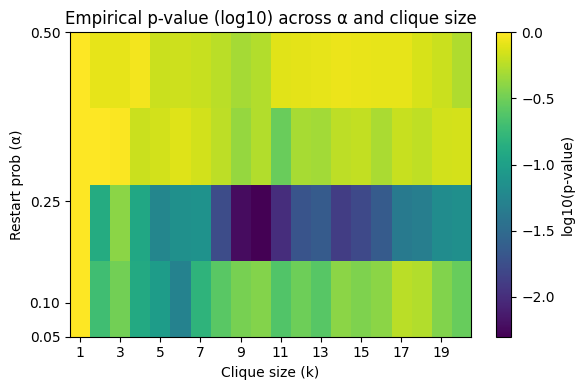

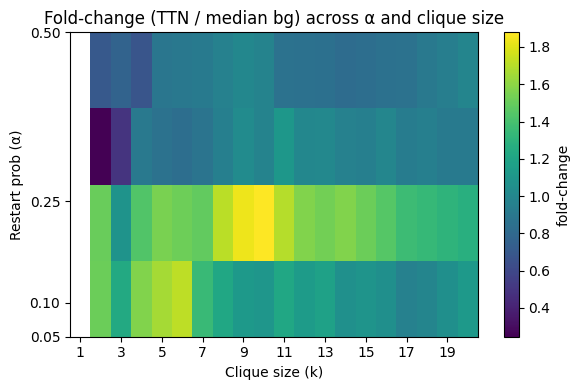

📈 Heatmaps rendered
🏆 Best by p-value    → α=0.1, size=4, p-value=0.004995
🥇 Best by fold-change → α=0.1, size=4, fold-change=1.879
🎉 All done!


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Parameters ---
alphas          = [0.05, 0.1, 0.25, 0.5]
max_clique_size = 20
num_samples     = 10000

print("🔄 Starting full sweep over alphas and sizes...")

# --- Collect all size-wise results ---
records = []
for alpha in alphas:
    print(f"→ Running optimize_clique_size for α={alpha}")
    sizes, scores, pvals, folds, _ = optimize_clique_size(
        contact_matrix=contact_matrix_zero,
        max_clique_size=max_clique_size,
        seed_bin=TTN_BIN,
        num_samples=num_samples,
        clique_alg=cf.random_walk,
        alpha=alpha,
        neighbors=neighbors,
        cdfs=cdfs,
        num_molecules=3000
    )
    print(f"   • Completed α={alpha} (collected sizes 1–{max_clique_size})")
    for size, pval, fold in zip(sizes, pvals, folds):
        records.append({
            'alpha': alpha,
            'size':  size,
            'pval':  pval,
            'fold':  fold
        })

df = pd.DataFrame(records)
print(f"✅ DataFrame assembled: {df.shape[0]} rows")

# --- Pivot into matrices ---
pval_mat = df.pivot(index='alpha', columns='size', values='pval')
fold_mat = df.pivot(index='alpha', columns='size', values='fold')

print("📊 Plotting heatmaps...")

# 1) p-value heatmap (log10 scale)
plt.figure(figsize=(6,4))
plt.title('Empirical p-value (log10) across α and clique size')
plt.imshow(np.log10(pval_mat), aspect='auto', origin='lower',
           extent=[1-0.5, max_clique_size+0.5, min(alphas), max(alphas)])
plt.colorbar(label='log10(p-value)')
plt.xlabel('Clique size (k)')
plt.ylabel('Restart prob (α)')
plt.xticks(range(1, max_clique_size+1, 2))
plt.yticks(alphas)
plt.tight_layout()

# 2) Fold-change heatmap
plt.figure(figsize=(6,4))
plt.title('Fold-change (TTN / median bg) across α and clique size')
plt.imshow(fold_mat, aspect='auto', origin='lower',
           extent=[1-0.5, max_clique_size+0.5, min(alphas), max(alphas)])
plt.colorbar(label='fold-change')
plt.xlabel('Clique size (k)')
plt.ylabel('Restart prob (α)')
plt.xticks(range(1, max_clique_size+1, 2))
plt.yticks(alphas)
plt.tight_layout()

plt.show()
print("📈 Heatmaps rendered")

# --- Print best combos ---
best_p = df.loc[df['pval'].idxmin()]
best_f = df.loc[df['fold'].idxmax()]
print(f"🏆 Best by p-value    → α={best_p.alpha}, size={best_p.size}, p-value={best_p.pval:.4g}")
print(f"🥇 Best by fold-change → α={best_f.alpha}, size={best_f.size}, fold-change={best_f.fold:.4g}")

print("🎉 All done!")

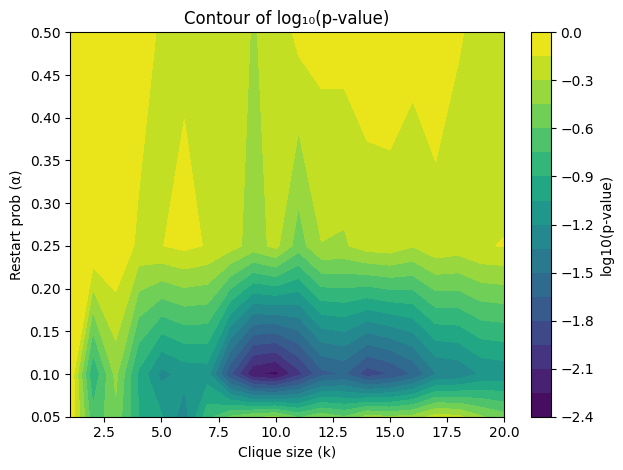

In [17]:

# 3) Contour of log10 p-value over the full grid
import numpy as np
alpha_vals = pval_mat.index.values
size_vals  = pval_mat.columns.values
AA, SS = np.meshgrid(alpha_vals, size_vals, indexing='ij')
Z = np.log10(pval_mat.values)

plt.figure()
cp = plt.contourf(SS, AA, Z, levels=20)
plt.colorbar(cp, label='log10(p-value)')
plt.xlabel('Clique size (k)')
plt.ylabel('Restart prob (α)')
plt.title('Contour of log₁₀(p-value)')
plt.tight_layout()

plt.show()

Most significant combination:
α = 0.100, k = 10, p-value = 5.00e-03
log₁₀(p-value) = -2.301


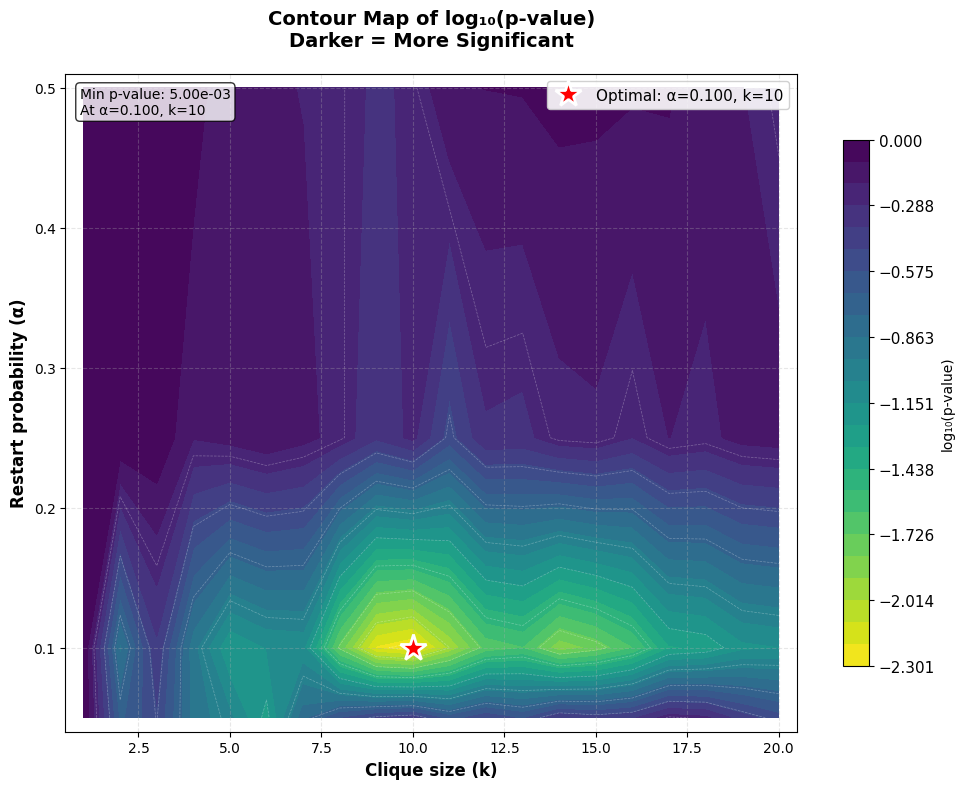

In [18]:
# Enhanced contour plot of log10 p-value over the full grid
import numpy as np
import matplotlib.pyplot as plt

# Get data
alpha_vals = pval_mat.index.values
size_vals = pval_mat.columns.values
AA, SS = np.meshgrid(alpha_vals, size_vals, indexing='ij')
Z = np.log10(pval_mat.values)

# Find the most significant point (minimum log10 p-value)
min_idx = np.unravel_index(np.nanargmin(Z), Z.shape)
optimal_alpha = alpha_vals[min_idx[0]]
optimal_size = size_vals[min_idx[1]]
min_log_pval = Z[min_idx]
actual_pval = 10**min_log_pval

print(f"Most significant combination:")
print(f"α = {optimal_alpha:.3f}, k = {optimal_size}, p-value = {actual_pval:.2e}")
print(f"log₁₀(p-value) = {min_log_pval:.3f}")

# Create enhanced figure
plt.figure(figsize=(10, 8))

# Create contour plot with more levels for smoother appearance
levels = np.linspace(np.nanmin(Z), np.nanmax(Z), 25)
cp = plt.contourf(SS, AA, Z, levels=levels, cmap='viridis_r')

# Add contour lines for better readability
contour_lines = plt.contour(SS, AA, Z, levels=10, colors='white', alpha=0.3, linewidths=0.5)

# Enhanced colorbar
cbar = plt.colorbar(cp, label='log₁₀(p-value)', shrink=0.8)
cbar.ax.tick_params(labelsize=11)

# Mark the optimal point
plt.plot(optimal_size, optimal_alpha, 'r*', markersize=20, 
         markeredgecolor='white', markeredgewidth=2, 
         label=f'Optimal: α={optimal_alpha:.3f}, k={optimal_size}')

# Enhanced labels and title
plt.xlabel('Clique size (k)', fontsize=12, fontweight='bold')
plt.ylabel('Restart probability (α)', fontsize=12, fontweight='bold')
plt.title('Contour Map of log₁₀(p-value)\nDarker = More Significant', 
          fontsize=14, fontweight='bold', pad=20)

# Add grid for better readability
plt.grid(True, alpha=0.3, linestyle='--')

# Legend
plt.legend(loc='upper right', fontsize=11, framealpha=0.9)

# Set axis limits with some padding
plt.xlim(size_vals.min() - 0.5, size_vals.max() + 0.5)
plt.ylim(alpha_vals.min() - 0.01, alpha_vals.max() + 0.01)

# Add text box with statistics
textstr = f'Min p-value: {actual_pval:.2e}\nAt α={optimal_alpha:.3f}, k={optimal_size}'
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

Most significant combination:
α = 0.100, k = 10, p-value = 5.00e-03
log₁₀(p-value) = -2.301


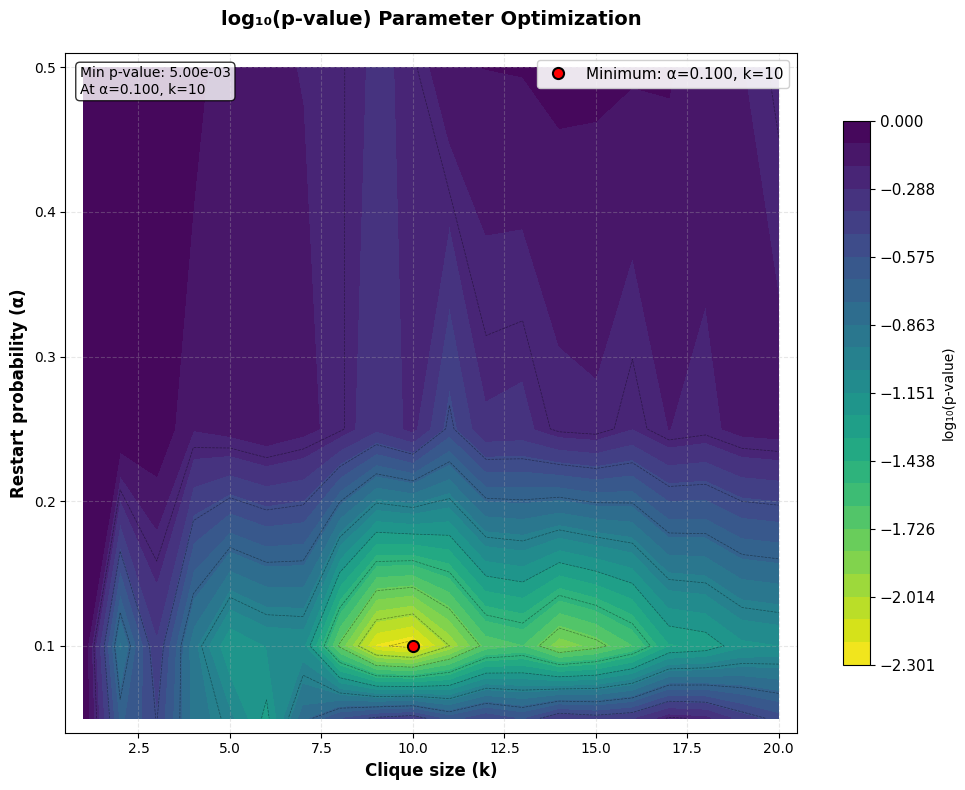

In [27]:
# Enhanced contour plot of log10 p-value over the full grid
import numpy as np
import matplotlib.pyplot as plt

# Get data
alpha_vals = pval_mat.index.values
size_vals = pval_mat.columns.values
AA, SS = np.meshgrid(alpha_vals, size_vals, indexing='ij')
Z = np.log10(pval_mat.values)

# Find the most significant point (minimum log10 p-value)
min_idx = np.unravel_index(np.nanargmin(Z), Z.shape)
optimal_alpha = alpha_vals[min_idx[0]]
optimal_size = size_vals[min_idx[1]]
min_log_pval = Z[min_idx]
actual_pval = 10**min_log_pval

print(f"Most significant combination:")
print(f"α = {optimal_alpha:.3f}, k = {optimal_size}, p-value = {actual_pval:.2e}")
print(f"log₁₀(p-value) = {min_log_pval:.3f}")

# Create enhanced figure
plt.figure(figsize=(10, 8))

# Create contour plot with more levels for smoother appearance
levels = np.linspace(np.nanmin(Z), np.nanmax(Z), 25)
cp = plt.contourf(SS, AA, Z, levels=levels, cmap='viridis_r')

# Add contour lines for better readability
contour_lines = plt.contour(SS, AA, Z, levels=10, colors='black', alpha=0.4, linewidths=0.5)

# Enhanced colorbar
cbar = plt.colorbar(cp, label='log₁₀(p-value)', shrink=0.8)
cbar.ax.tick_params(labelsize=11)

# Mark the optimal point with professional styling
plt.plot(optimal_size, optimal_alpha, 'o', color='red', markersize=8, 
         markeredgecolor='black', markeredgewidth=1.5, 
         label=f'Minimum: α={optimal_alpha:.3f}, k={optimal_size}')

# Enhanced labels and title
plt.xlabel('Clique size (k)', fontsize=12, fontweight='bold')
plt.ylabel('Restart probability (α)', fontsize=12, fontweight='bold')
plt.title('log₁₀(p-value) Parameter Optimization', 
          fontsize=14, fontweight='bold', pad=20)

# Add grid for better readability
plt.grid(True, alpha=0.3, linestyle='--')

# Legend
plt.legend(loc='upper right', fontsize=11, framealpha=0.9)

# Set axis limits with some padding
plt.xlim(size_vals.min() - 0.5, size_vals.max() + 0.5)
plt.ylim(alpha_vals.min() - 0.01, alpha_vals.max() + 0.01)

# Add text box with statistics
textstr = f'Min p-value: {actual_pval:.2e}\nAt α={optimal_alpha:.3f}, k={optimal_size}'
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

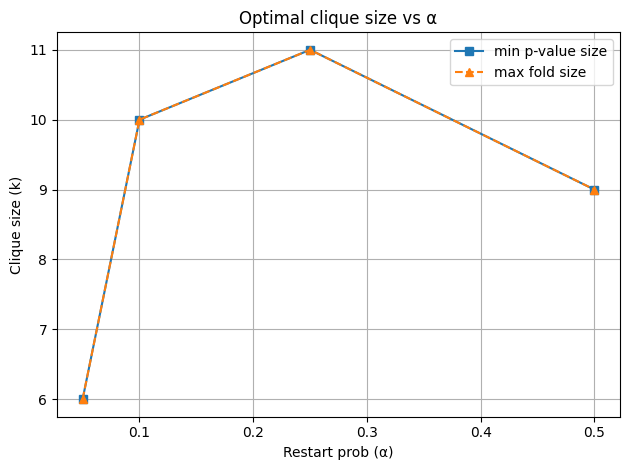

In [16]:
# --- 3 new plots to add after df is assembled ---

# 1) Line plots of p-value vs alpha for selected sizes
# plt.figure()
# for size in [5, 10, 15, max_clique_size]:
#     sub = df[df['size'] == size]
#     plt.plot(sub['alpha'], sub['pval'], marker='o', label=f'size={size}')
# plt.xlabel('Restart prob (α)')
# plt.ylabel('Empirical p-value')
# plt.yscale('log')
# plt.title('p-value vs α for selected clique sizes')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()

# 2) Optimal size vs alpha (by lowest p-value and highest fold)
best_p_per_alpha = df.loc[df.groupby('alpha')['pval'].idxmin()]
best_f_per_alpha = df.loc[df.groupby('alpha')['fold'].idxmax()]

plt.figure()
plt.plot(best_p_per_alpha['alpha'], best_p_per_alpha['size'],
         marker='s', linestyle='-', label='min p-value size')
plt.plot(best_f_per_alpha['alpha'], best_f_per_alpha['size'],
         marker='^', linestyle='--', label='max fold size')
plt.xlabel('Restart prob (α)')
plt.ylabel('Clique size (k)')
plt.title('Optimal clique size vs α')
plt.legend()
plt.grid(True)
plt.tight_layout()


## Greedy Tuning

In [ ]:
def optimize_clique_size(contact_matrix, max_clique_size, seed_bin, num_samples=1000):
    print(f"Starting optimize_clique_size: max_clique_size={max_clique_size}, seed_bin={seed_bin}, num_samples={num_samples}")

    # 1) Compute the full-size TTN clique once
    ttn_full = cf.find_greedy_clique(contact_matrix, max_clique_size, seed_bin)
    print(f"Computed TTN full clique of size {len(ttn_full)}")

    # 2) Sample background cliques at full size
    bg_full = []
    for _ in tqdm(range(num_samples), desc="Sampling background cliques"):
        random_bin = np.random.randint(contact_matrix.shape[0])  
        bg_full.append(
            cf.find_greedy_clique(contact_matrix, max_clique_size, random_bin)
        )
    print("Background sampling complete.")

    sizes = list(range(1, max_clique_size + 1))
    ttn_scores, p_values, fold_changes = [], [], []
    bg_dists = {}

    
    print("Processing clique sizes...")
    for size in range(sizes):
        print(f"\nSize {size}/{max_clique_size}")

        # TTN subclique and score
        ttn_sub = ttn_full[:size]
        ttn_score = core.stats.calculate_avg_interaction_strength(contact_matrix, ttn_sub)
        print(f"  TTN score: {ttn_score:.4f}")

        # Background subcliques and scores
        bg_scores = [
            core.stats.calculate_avg_interaction_strength(contact_matrix, clique[:size])
            for clique in bg_full
        ]
        bg_dists[size] = bg_scores

        # Compute statistics
        median_bg = np.median(bg_scores)
        pval = (np.sum(np.array(bg_scores) >= ttn_score) + 1) / (num_samples + 1)
        fold = ttn_score / median_bg if median_bg != 0 else float('nan')

        print(f"  Median background: {median_bg:.4f}")
        print(f"  p-value: {pval:.4f}")
        print(f"  Fold change: {fold:.4f}")

        # Store
        ttn_scores.append(ttn_score)
        p_values.append(pval)
        fold_changes.append(fold)

    print("Completed optimize_clique_size")
    return sizes, ttn_scores, p_values, fold_changes, bg_dists

In [5]:
sizes, ttn_scores, pvals, folds, bg = optimize_clique_size(
    contact_matrix=contact_matrix_zero,
    max_clique_size=20,
    seed_bin=TTN_BIN,
    num_samples=5000
)

# then you can e.g. plot fold vs size or pval vs size

Starting optimize_clique_size: max_clique_size=20, seed_bin=4275, num_samples=5000
Computed TTN full clique of size 20


Sampling background cliques: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:19<00:00, 19.26it/s]


Background sampling complete.


Processing clique sizes:  30%|██████████████████████████████████████████                                                                                                  | 6/20 [00:00<00:00, 51.77it/s]


Size 1/20
  TTN score: 0.0000
  Median background: 0.0000
  p-value: 1.0000
  Fold change: nan

Size 2/20
  TTN score: 0.0003
  Median background: 0.0010
  p-value: 0.7193
  Fold change: 0.3198

Size 3/20
  TTN score: 0.0006
  Median background: 0.0038
  p-value: 0.7902
  Fold change: 0.1720

Size 4/20
  TTN score: 0.0007
  Median background: 0.0037
  p-value: 0.8620
  Fold change: 0.1753

Size 5/20
  TTN score: 0.0102
  Median background: 0.0033
  p-value: 0.0960
  Fold change: 3.1187

Size 6/20
  TTN score: 0.0073
  Median background: 0.0029
  p-value: 0.1116
  Fold change: 2.5021

Size 7/20
  TTN score: 0.0061
  Median background: 0.0027
  p-value: 0.1316
  Fold change: 2.2303

Size 8/20
  TTN score: 0.0051
  Median background: 0.0025
  p-value: 0.1396
  Fold change: 2.0658

Size 9/20
  TTN score: 0.0043
  Median background: 0.0022
  p-value: 0.1508
  Fold change: 1.9145

Size 10/20
  TTN score: 0.0037
  Median background: 0.0021
  p-value: 0.1632
  Fold change: 1.7821

Size 11/20


Processing clique sizes:  60%|███████████████████████████████████████████████████████████████████████████████████▍                                                       | 12/20 [00:00<00:00, 16.85it/s]

  Median background: 0.0019
  p-value: 0.1946
  Fold change: 1.6411

Size 12/20
  TTN score: 0.0029
  Median background: 0.0018
  p-value: 0.1962
  Fold change: 1.5870

Size 13/20
  TTN score: 0.0026
  Median background: 0.0019
  p-value: 0.1832
  Fold change: 1.3896

Size 14/20
  TTN score: 0.0024
  Median background: 0.0017
  p-value: 0.1912
  Fold change: 1.3617

Size 15/20
  TTN score: 0.0021


Processing clique sizes:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 15/20 [00:01<00:00, 10.63it/s]

  Median background: 0.0017
  p-value: 0.2070
  Fold change: 1.2808

Size 16/20
  TTN score: 0.0020
  Median background: 0.0016
  p-value: 0.2100
  Fold change: 1.2354

Size 17/20
  TTN score: 0.0018


Processing clique sizes:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 17/20 [00:01<00:00,  7.90it/s]

  Median background: 0.0015
  p-value: 0.2194
  Fold change: 1.1972

Size 18/20
  TTN score: 0.0017
  Median background: 0.0014
  p-value: 0.2350
  Fold change: 1.1786

Size 19/20
  TTN score: 0.0015


Processing clique sizes:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 19/20 [00:02<00:00,  6.03it/s]

  Median background: 0.0013
  p-value: 0.2669
  Fold change: 1.1484

Size 20/20
  TTN score: 0.0014


Processing clique sizes: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.74it/s]

  Median background: 0.0013
  p-value: 0.2889
  Fold change: 1.1282
Completed optimize_clique_size


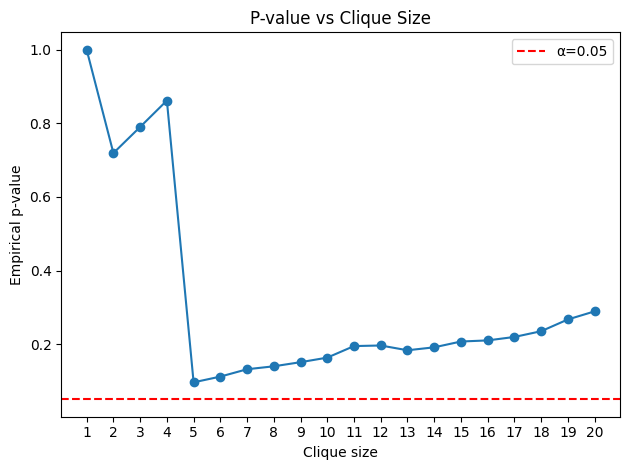

Optimal clique size = 5, p-value = 0.0960


In [6]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Plot p-value vs size
plt.figure()
plt.plot(sizes, pvals, marker='o', linestyle='-')
plt.axhline(0.05, color='red', linestyle='--', label='α=0.05')
plt.xlabel('Clique size')
plt.ylabel('Empirical p-value')
plt.title('P-value vs Clique Size')
plt.xticks(sizes)
plt.legend()
plt.tight_layout()
plt.show()

# 2) Choose the size with minimum p-value
opt_idx = int(np.argmin(pvals))
opt_size = sizes[opt_idx]
opt_pval = pvals[opt_idx]
print(f'Optimal clique size = {opt_size}, p-value = {opt_pval:.4f}')

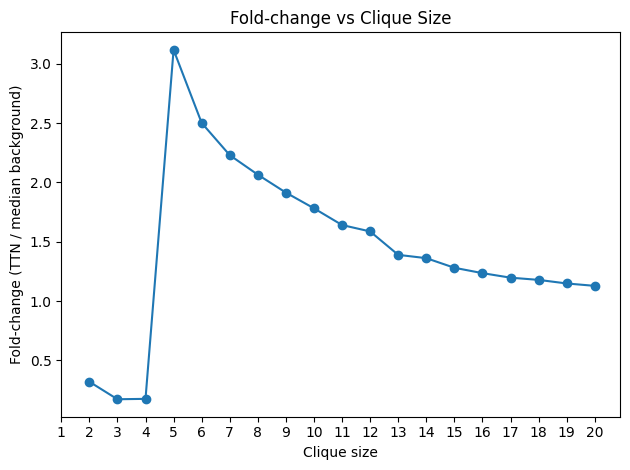

In [8]:
plt.figure()
plt.plot(sizes, folds, marker='o', linestyle='-')
plt.xlabel('Clique size')
plt.ylabel('Fold-change (TTN / median background)')
plt.title('Fold-change vs Clique Size')
plt.xticks(sizes)
plt.tight_layout()
plt.show()

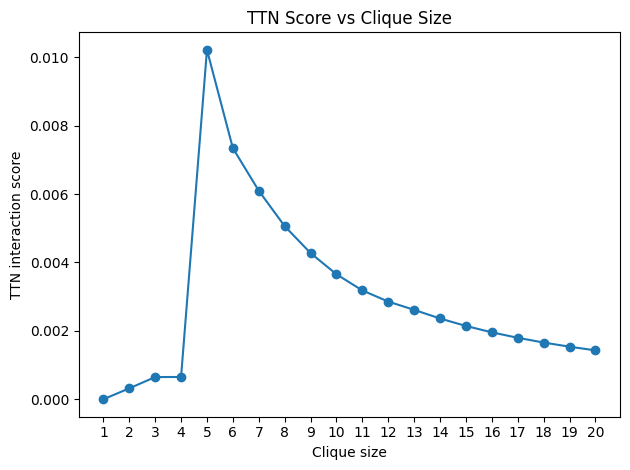

In [9]:
plt.figure()
plt.plot(sizes, ttn_scores, marker='o', linestyle='-')
plt.xlabel('Clique size')
plt.ylabel('TTN interaction score')
plt.title('TTN Score vs Clique Size')
plt.xticks(sizes)
plt.tight_layout()
plt.show()

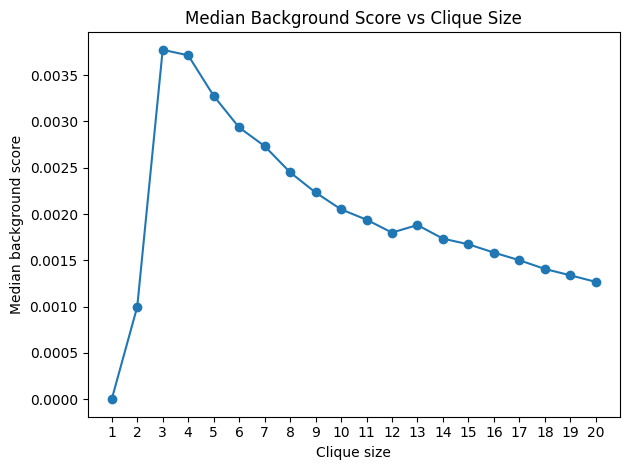

In [11]:
medians = [np.median(bg[size]) for size in sizes]
plt.figure()
plt.plot(sizes, medians, marker='o', linestyle='-')
plt.xlabel('Clique size')
plt.ylabel('Median background score')
plt.title('Median Background Score vs Clique Size')
plt.xticks(sizes)
plt.tight_layout()
plt.show()

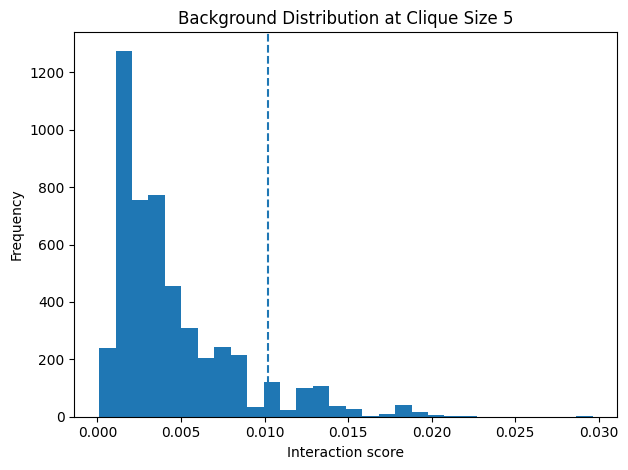

In [13]:
opt_p_idx = int(np.argmin(pvals))
opt_size = sizes[opt_p_idx]
bg_best = bg[opt_size]

plt.figure()
plt.hist(bg_best, bins=30)
plt.axvline(ttn_scores[opt_p_idx], linestyle='--')
plt.xlabel('Interaction score')
plt.ylabel('Frequency')
plt.title(f'Background Distribution at Clique Size {opt_size}')
plt.tight_layout()
plt.show()

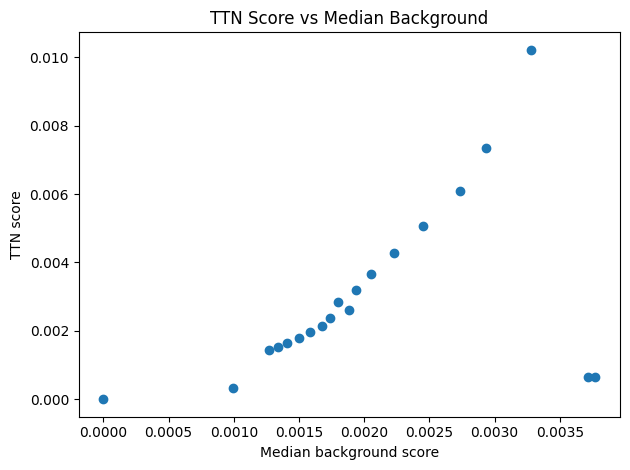

In [14]:
plt.figure()
plt.scatter(medians, ttn_scores)
plt.xlabel('Median background score')
plt.ylabel('TTN score')
plt.title('TTN Score vs Median Background')
plt.tight_layout()
plt.show()